# WoEEncoder (weight of evidence)
This encoder replaces the labels by the weight of evidence

**It only works for binary classification.**

The weight of evidence is given by: log( p(1) / p(0) )

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from feature_engine.encoding import WoEEncoder

from feature_engine.encoding import RareLabelEncoder #to reduce cardinality

In [2]:
def load_titanic():
    # Load dataset from OpenML
    data = pd.read_csv('https://www.openml.org/data/get_csv/16826755/phpMYEkMl')
    
    # Replace '?' with NaN
    data = data.replace('?', np.nan)
    
    # Extract first letter of cabin
    data['cabin'] = data['cabin'].astype(str).str[0]
    
    # Convert 'pclass' to categorical
    data['pclass'] = data['pclass'].astype('O')
    
    # Ensure 'age' contains only numeric data by coercing errors to NaN
    data['age'] = pd.to_numeric(data['age'], errors='coerce')
    
    # Fill missing values in 'age' with the median age
    data['age'].fillna(data['age'].median(), inplace=True)
    
    # Ensure 'fare' contains only numeric data by coercing errors to NaN
    data['fare'] = pd.to_numeric(data['fare'], errors='coerce')
    
    # Fill missing values in 'fare' with the median fare
    data['fare'].fillna(data['fare'].median(), inplace=True)
    
    # Fill missing values in 'embarked' with 'C'
    data['embarked'].fillna('C', inplace=True)
    
    # Drop irrelevant columns
    data.drop(labels=['boat', 'body', 'home.dest'], axis=1, inplace=True)
    
    return data

# Load the data
data = load_titanic()

# Display the first few rows of the cleaned data
data.head()

C:\Users\devanshu.tayal\AppData\Local\Temp\ipykernel_10924\2365807979.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['age'].fillna(data['age'].median(), inplace=True)
C:\Users\devanshu.tayal\AppData\Local\Temp\ipykernel_10924\2365807979.py:24: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always b

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B,S
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C,S
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C,S
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C,S
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C,S


In [3]:
X = data.drop(['survived', 'name', 'ticket'], axis=1)
y = data.survived

# we will encode the below variables, they have no missing values
X[['cabin', 'pclass', 'embarked']].isnull().sum()

cabin       0
pclass      0
embarked    0
dtype: int64

In [4]:
# let's separate into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

X_train.shape, X_test.shape

((916, 8), (393, 8))

In [5]:
## Rare value encoder first to reduce the cardinality
# see RareLabelEncoder jupyter notebook for more details on this encoder
rare_encoder = RareLabelEncoder(tol=0.03,
                                n_categories=2, 
                                variables=['cabin', 'pclass', 'embarked'])

rare_encoder.fit(X_train)

# transform
train_t = rare_encoder.transform(X_train)
test_t = rare_encoder.transform(X_test)

The WoERatioEncoder() replaces categories by the weight of evidence or by the ratio between the probability of the target = 1 and the probability of the target = 0.

The weight of evidence is given by: log(P(X=xj|Y = 1)/P(X=xj|Y=0))

**Note:** This categorical encoding is exclusive for binary classification.

For example in the variable colour, if the mean of the target = 1 for blue is 0.8 and the mean of the target = 0 is 0.2, blue will be replaced by: np.log(0.8/0.2) = 1.386

### Note:
The division by 0 is not defined and the log(0) is not defined. Thus, if p(0) = 0 or p(1) = 0 for woe , in any of the variables, the encoder will return an error.

The encoder will encode only categorical variables (type 'object'). A list of variables can be passed as an argument. If no variables are passed as argument, the encoder will find and encode all categorical variables (object type).

For details on the calculation of the weight of evidence visit:
https://www.listendata.com/2015/03/weight-of-evidence-woe-and-information.html

## Weight of evidence

In [6]:
woe_enc = WoEEncoder(variables=['cabin', 'pclass', 'embarked'])

# to fit you need to pass the target y
woe_enc.fit(train_t, y_train)

WoEEncoder(variables=['cabin', 'pclass', 'embarked'])

In [7]:
woe_enc.encoder_dict_

{'cabin': {'B': 1.6299623810120747,
  'C': 0.7217038208351837,
  'D': 1.405081209799324,
  'E': 1.405081209799324,
  'Rare': 0.7387452866900354,
  'n': -0.35752781962490193},
 'pclass': {1: 0.9453018143294478,
  2: 0.21009172435857942,
  3: -0.5841726684724614},
 'embarked': {'C': 0.6999054533737715,
  'Q': -0.05044494288988759,
  'S': -0.20113381737960143}}

In [8]:
# transform and visualise the data

train_t = woe_enc.transform(train_t)
test_t = woe_enc.transform(test_t)

test_t.sample(5)

,pclass,sex,age,sibsp,parch,fare,cabin,embarked
1287,-0.584173,male,51.0,0,0,7.750,-0.357528,-0.201134
461,0.210092,male,47.0,0,0,15.000,-0.357528,-0.201134
14,0.945302,male,80.0,0,0,30.000,0.738745,-0.201134
794,-0.584173,female,5.0,0,0,12.475,-0.357528,-0.201134
224,0.945302,male,45.5,0,0,28.500,0.721704,-0.201134


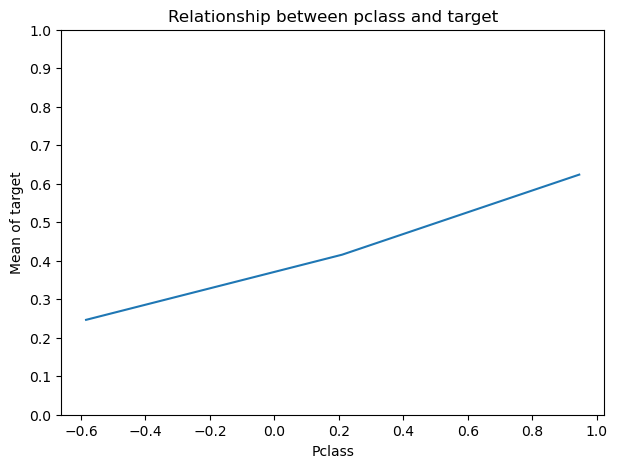

In [9]:
''' The WoEEncoder has the characteristic that return monotonic
 variables, that is, encoded variables which values increase as the target increases'''

# let's explore the monotonic relationship
plt.figure(figsize=(7,5))
pd.concat([test_t,y_test], axis=1).groupby("pclass")["survived"].mean().plot()
#plt.xticks([0,1,2])
plt.yticks(np.arange(0,1.1,0.1))
plt.title("Relationship between pclass and target")
plt.xlabel("Pclass")
plt.ylabel("Mean of target")
plt.show()

## Automatically select the variables
This encoder will select all categorical variables to encode, when no variables are specified when calling the encoder.

In [10]:
ratio_enc = WoEEncoder()

# to fit we need to pass the target y
ratio_enc.fit(train_t, y_train)

WoEEncoder()

In [11]:
# transform and visualise the data

train_t = ratio_enc.transform(train_t)
test_t = ratio_enc.transform(test_t)

test_t.head()

,pclass,sex,age,sibsp,parch,fare,cabin,embarked
1139,-0.584173,-0.99882,38.0,0,0,7.8958,-0.357528,-0.201134
533,0.210092,1.45312,21.0,0,1,21.0000,-0.357528,-0.201134
459,0.210092,-0.99882,42.0,1,0,27.0000,-0.357528,-0.201134
1150,-0.584173,-0.99882,28.0,0,0,14.5000,-0.357528,-0.201134
393,0.210092,-0.99882,25.0,0,0,31.5000,-0.357528,-0.201134
